In [1]:
import logging

import numpy as np
import probtorch
import torch

import bouncing_ball
import bouncing_ball_data
import combinators
import importance
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 75 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [6]:
num_particles = 100

In [7]:
bouncing_ball_step = combinators.Model(bouncing_ball.bouncing_ball_step, {}, {
    'delta_t': torch.ones(1),
})

In [8]:
prior_init_params = {
    'position_0': {
        'loc': torch.rand(2) * Boundary,
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'angle': {
            'concentration1': torch.ones(()),
            'concentration0': torch.ones(()),
        },
        'scale': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [9]:
init_bouncing_ball = combinators.Model(bouncing_ball.init_bouncing_ball,
                                       hyper=prior_init_params)

In [10]:
bouncing_ball_smc = importance.ImportanceResampler.smc(
    bouncing_ball_step, T, initializer=init_bouncing_ball
)

In [11]:
variational_init_params = {
    'position_0': {
        'loc': torch.rand(2) * Boundary,
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.Tensor([0.40, 0.20, 0.20, 0.20]),
    },
    'alpha_2': {
        'concentration': torch.Tensor([0.20, 0.40, 0.20, 0.20]),
    },
    'alpha_3': {
        'concentration': torch.Tensor([0.20, 0.20, 0.40, 0.20]),
    },
    'alpha_4': {
        'concentration': torch.Tensor([0.20, 0.20, 0.20, 0.40]),
    },
    'directions': {
        'angle': {
            'concentration1': torch.ones(()),
            'concentration0': torch.ones(()),
        },
        'scale': {
            'loc': torch.ones(4, 2, 2),
            'scale': torch.ones(4, 2, 2) * 0.1,
        },
    },
}

In [12]:
step_proposal = combinators.Model(bouncing_ball.bouncing_ball_step,
                                  hyper={'delta_t': torch.ones(1)})

In [13]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['displacement_%d' % i] = displacements[i-1]
    
    return trajectory, displacements, data

In [14]:
def accumulate_trajectory(inference):
    result = torch.zeros(num_particles, len(trajectory), 2)
    result[:, 0] = inference['position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['displacement_%d' % (t+1)].value
    return result

In [15]:
def graph_position_trajectory(positions, T, s):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    plt.savefig('position_trajectory_%d.pdf' % s)

In [16]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [17]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

10/26/2018 13:10:19 EUBO=9.47918510e+00 at epoch 1
10/26/2018 13:10:20 EUBO=7.41840744e+00 at epoch 2
10/26/2018 13:10:21 EUBO=8.81787872e+00 at epoch 3
10/26/2018 13:10:22 EUBO=8.36215878e+00 at epoch 4
10/26/2018 13:10:23 EUBO=9.38410854e+00 at epoch 5
10/26/2018 13:10:24 EUBO=8.16082859e+00 at epoch 6
10/26/2018 13:10:25 EUBO=7.59590483e+00 at epoch 7
10/26/2018 13:10:26 EUBO=9.04770851e+00 at epoch 8
10/26/2018 13:10:27 EUBO=7.87180138e+00 at epoch 9
10/26/2018 13:10:28 EUBO=3.90825677e+00 at epoch 10
10/26/2018 13:10:29 EUBO=8.77083302e-01 at epoch 11
10/26/2018 13:10:30 EUBO=5.07784653e+00 at epoch 12
10/26/2018 13:10:31 EUBO=4.61073494e+00 at epoch 13
10/26/2018 13:10:32 EUBO=3.03799152e+00 at epoch 14
10/26/2018 13:10:32 EUBO=5.04594135e+00 at epoch 15
10/26/2018 13:10:33 EUBO=2.84756756e+00 at epoch 16
10/26/2018 13:10:34 EUBO=4.30389833e+00 at epoch 17
10/26/2018 13:10:35 EUBO=1.99394989e+00 at epoch 18
10/26/2018 13:10:36 EUBO=2.48613381e+00 at epoch 19
10/26/2018 13:10:37 E

Epoch   373: reducing learning rate of group 0 to 5.0000e-02.


10/26/2018 13:16:00 EUBO=-3.65301228e+00 at epoch 375
10/26/2018 13:16:01 EUBO=-3.29026842e+00 at epoch 376
10/26/2018 13:16:02 EUBO=-4.12809181e+00 at epoch 377
10/26/2018 13:16:03 EUBO=-3.68647289e+00 at epoch 378
10/26/2018 13:16:04 EUBO=-4.40368176e+00 at epoch 379
10/26/2018 13:16:05 EUBO=-3.08945560e+00 at epoch 380
10/26/2018 13:16:06 EUBO=-3.58825397e+00 at epoch 381
10/26/2018 13:16:07 EUBO=-3.26576328e+00 at epoch 382
10/26/2018 13:16:08 EUBO=-3.64204121e+00 at epoch 383
10/26/2018 13:16:09 EUBO=-3.89340687e+00 at epoch 384
10/26/2018 13:16:09 EUBO=-3.76617432e+00 at epoch 385
10/26/2018 13:16:10 EUBO=-4.09504128e+00 at epoch 386
10/26/2018 13:16:11 EUBO=-3.66378117e+00 at epoch 387
10/26/2018 13:16:12 EUBO=-4.06793785e+00 at epoch 388
10/26/2018 13:16:13 EUBO=-4.43013382e+00 at epoch 389
10/26/2018 13:16:14 EUBO=-3.66636848e+00 at epoch 390
10/26/2018 13:16:15 EUBO=-3.65727139e+00 at epoch 391
10/26/2018 13:16:16 EUBO=-3.78519249e+00 at epoch 392
10/26/2018 13:16:17 EUBO=-4.

Epoch   574: reducing learning rate of group 0 to 2.5000e-02.


10/26/2018 13:19:02 EUBO=-5.41655731e+00 at epoch 576
10/26/2018 13:19:03 EUBO=-5.13164234e+00 at epoch 577
10/26/2018 13:19:04 EUBO=-5.22379494e+00 at epoch 578
10/26/2018 13:19:05 EUBO=-4.95864582e+00 at epoch 579
10/26/2018 13:19:06 EUBO=-5.28078175e+00 at epoch 580
10/26/2018 13:19:07 EUBO=-5.40574837e+00 at epoch 581
10/26/2018 13:19:08 EUBO=-5.22414875e+00 at epoch 582
10/26/2018 13:19:09 EUBO=-5.26688194e+00 at epoch 583
10/26/2018 13:19:10 EUBO=-5.14915276e+00 at epoch 584
10/26/2018 13:19:11 EUBO=-5.36831379e+00 at epoch 585
10/26/2018 13:19:11 EUBO=-5.21450233e+00 at epoch 586
10/26/2018 13:19:12 EUBO=-5.38799763e+00 at epoch 587
10/26/2018 13:19:13 EUBO=-5.44055462e+00 at epoch 588
10/26/2018 13:19:14 EUBO=-5.29967022e+00 at epoch 589
10/26/2018 13:19:15 EUBO=-5.64997005e+00 at epoch 590
10/26/2018 13:19:16 EUBO=-5.32262039e+00 at epoch 591
10/26/2018 13:19:17 EUBO=-5.40067387e+00 at epoch 592
10/26/2018 13:19:18 EUBO=-5.20407677e+00 at epoch 593
10/26/2018 13:19:19 EUBO=-5.

Epoch   775: reducing learning rate of group 0 to 1.2500e-02.


10/26/2018 13:22:05 EUBO=-6.33722878e+00 at epoch 777
10/26/2018 13:22:05 EUBO=-6.21882153e+00 at epoch 778
10/26/2018 13:22:06 EUBO=-6.11552143e+00 at epoch 779
10/26/2018 13:22:07 EUBO=-6.44883442e+00 at epoch 780
10/26/2018 13:22:08 EUBO=-6.09492111e+00 at epoch 781
10/26/2018 13:22:09 EUBO=-6.46338558e+00 at epoch 782
10/26/2018 13:22:10 EUBO=-6.39287090e+00 at epoch 783
10/26/2018 13:22:11 EUBO=-6.20646286e+00 at epoch 784
10/26/2018 13:22:12 EUBO=-6.66823387e+00 at epoch 785
10/26/2018 13:22:13 EUBO=-6.33851147e+00 at epoch 786
10/26/2018 13:22:13 EUBO=-6.13265133e+00 at epoch 787
10/26/2018 13:22:14 EUBO=-6.19294548e+00 at epoch 788
10/26/2018 13:22:15 EUBO=-7.02557755e+00 at epoch 789
10/26/2018 13:22:16 EUBO=-6.28462601e+00 at epoch 790
10/26/2018 13:22:17 EUBO=-6.22577381e+00 at epoch 791
10/26/2018 13:22:18 EUBO=-6.74150276e+00 at epoch 792
10/26/2018 13:22:19 EUBO=-6.54830265e+00 at epoch 793
10/26/2018 13:22:20 EUBO=-6.48345947e+00 at epoch 794
10/26/2018 13:22:21 EUBO=-6.

Epoch   976: reducing learning rate of group 0 to 6.2500e-03.


10/26/2018 13:25:09 EUBO=-6.97020817e+00 at epoch 978
10/26/2018 13:25:10 EUBO=-7.08228588e+00 at epoch 979
10/26/2018 13:25:11 EUBO=-6.75698948e+00 at epoch 980
10/26/2018 13:25:12 EUBO=-6.97961903e+00 at epoch 981
10/26/2018 13:25:13 EUBO=-7.00525379e+00 at epoch 982
10/26/2018 13:25:14 EUBO=-6.86645412e+00 at epoch 983
10/26/2018 13:25:15 EUBO=-7.32161522e+00 at epoch 984
10/26/2018 13:25:16 EUBO=-6.81674767e+00 at epoch 985
10/26/2018 13:25:17 EUBO=-6.90833855e+00 at epoch 986
10/26/2018 13:25:18 EUBO=-7.02033710e+00 at epoch 987
10/26/2018 13:25:19 EUBO=-6.85820007e+00 at epoch 988
10/26/2018 13:25:20 EUBO=-6.96717930e+00 at epoch 989
10/26/2018 13:25:21 EUBO=-7.06648827e+00 at epoch 990
10/26/2018 13:25:22 EUBO=-6.89610195e+00 at epoch 991
10/26/2018 13:25:23 EUBO=-6.89940262e+00 at epoch 992
10/26/2018 13:25:24 EUBO=-6.94020367e+00 at epoch 993
10/26/2018 13:25:25 EUBO=-7.09755230e+00 at epoch 994
10/26/2018 13:25:26 EUBO=-7.10595036e+00 at epoch 995
10/26/2018 13:25:27 EUBO=-6.

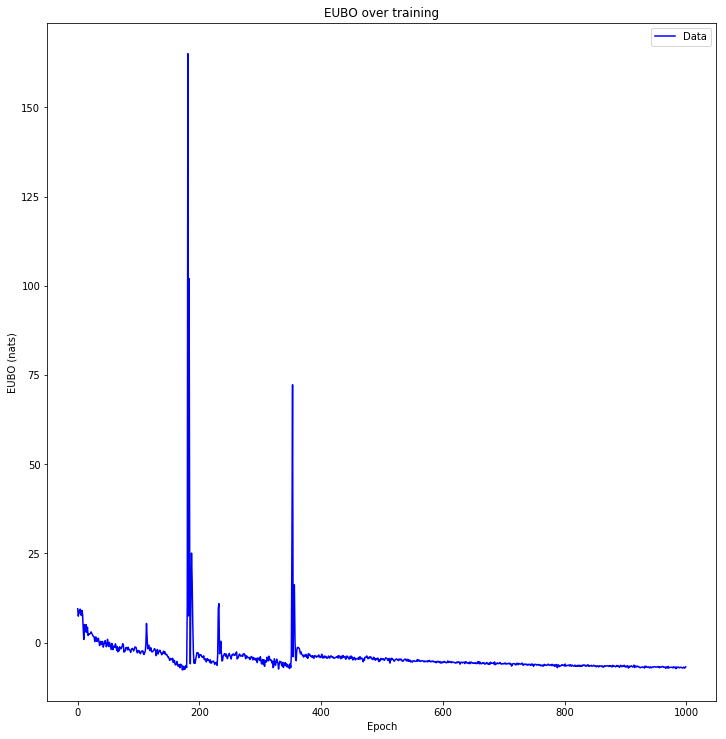

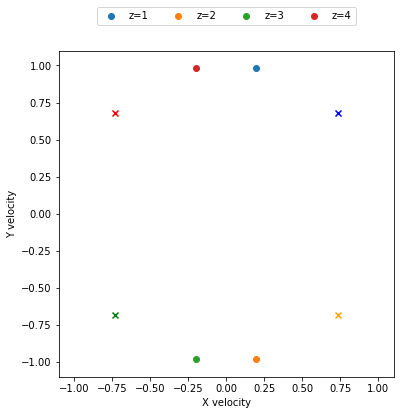

In [18]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)
    init_proposal = combinators.Model(bouncing_ball.init_bouncing_ball,
                                      trainable=variational_init_params)
    
    importance_sampler = importance.ImportanceSampler(bouncing_ball_smc,
                                                      init_proposal)
    
    inference, trained_params, eubos = importance.variational_importance(
        num_particles, importance_sampler, 1000, data,
        use_cuda=False, lr=1e-1, inclusive_kl=True,
        patience=200,
    )
    trained_params = init_proposal.args_vardict(())
    utils.plot_evidence_bounds(eubos, False)
    
    init_posterior = combinators.Model(bouncing_ball.init_bouncing_ball,
                                       hyper=trained_params)
    bouncing_ball_posterior = combinators.Reduce.sequence(step_proposal, T,
                                                          initializer=init_posterior)
    inference = importance.ResamplerTrace(inference.num_particles, data=data)
    bouncing_ball_posterior.simulate(trace=inference)
    inference = bouncing_ball_posterior.trace
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = torch.stack([inferred_trajectory[:, t+1] for t in range(T)], dim=1).mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['displacement_%d' % (t+1)].value for t in range(T)], dim=1).mean(dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_position_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    alpha = torch.tensor(trained_params['directions']['angle']['concentration1'])
    beta = torch.tensor(trained_params['directions']['angle']['concentration0'])
    mean_angle = torch.distributions.Beta(alpha, beta).mean  * np.pi/2
    modal_directions[s] = bouncing_ball.reflect_directions(mean_angle)
    mean_angle = inference['directions__angle'].value.mean(dim=0).detach().cpu() * np.pi/2
    final_mus[s] = bouncing_ball.reflect_directions(mean_angle).numpy()
    final_covs[s] = inference['directions__scale'].value.mean(dim=0).detach().cpu().numpy()
    for k in range(K):
        As_pred[s][k] = inference['A_%d' % (k+1)].value.mean(dim=0).detach().cpu().numpy()
    
    plt.close('all')

graph_velocity_frequencies(modal_directions.detach().numpy())

In [19]:
import bouncing_ball_plots

In [20]:
fs = 3 ## figure size
vmax = 0.3 ## cmap maximum value, to make off-diagonal elements more visible
width_space = 0.05 # space between figures
height_space = 0.05 # space between figures
cov_flag = False # plot the covariances or not
legend_flag = False # plot the legend bar or not
save_flag = True ## save or not

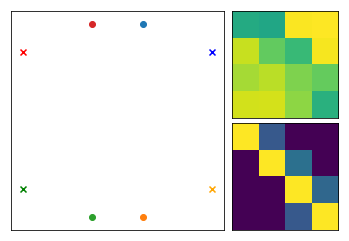

In [21]:
## plot method 1
bouncing_ball_plots.plot_circle_transition(init_v, final_mus, final_covs,
                                           As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

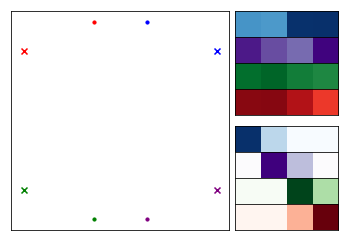

In [22]:
## plot method 2
bouncing_ball_plots.plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

In [23]:
def plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag):

    As_infer = As_pred / As_pred.sum(-1)[:, :, None]
    As_infer = As_infer.mean(0)
    As_true_ave = As_true.mean(0)

    fig = plt.figure(figsize=(fs*1.5 + width_space,fs + height_space))
    gs1 = gridspec.GridSpec(1, 1)
    # , width_ratios=[2,1], height_ratios=[1,1]
    gs1.update(left=0.0, bottom=0.0, right=(2/3), top=1.0, wspace=width_space, hspace=height_space)
    ax1 = fig.add_subplot(gs1[0])

    # ax3 = fig.add_subplot(gs[1, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])

    gs2 = gridspec.GridSpec(4, 1)
    gs2.update(left=2/3 + (1/3)*width_space, bottom=0.5+(1/2)*width_space, right=1.0, top=1.0, wspace=0, hspace=0)
    ax2 = fig.add_subplot(gs2[0, 0])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = fig.add_subplot(gs2[1, 0])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(gs2[2, 0])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax5 = fig.add_subplot(gs2[3, 0])
    ax5.set_xticks([])
    ax5.set_yticks([])

    gs3 = gridspec.GridSpec(4, 1)
    gs3.update(left=2/3 + (1/3)*width_space, bottom=0.0, right=1.0, top=0.5 - (1/2)*width_space, wspace=0, hspace=0)
    ax6 = fig.add_subplot(gs3[0, 0])
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax7 = fig.add_subplot(gs3[1, 0])
    ax7.set_xticks([])
    ax7.set_yticks([])
    ax8 = fig.add_subplot(gs3[2, 0])
    ax8.set_xticks([])
    ax8.set_yticks([])
    ax9 = fig.add_subplot(gs3[3, 0])
    ax9.set_xticks([])
    ax9.set_yticks([])
    markersize = 10.0
    colors = ['b', 'Purple', 'g', 'r']
    ## plot left one
    ax1.scatter(init_v[:,0], init_v[:,1], s=markersize, color=colors[0], label='z=1')
    ax1.scatter(init_v[:,0], -init_v[:,1], s=markersize, color=colors[1], label='z=2')
    ax1.scatter(-init_v[:,0], -init_v[:,1], s=markersize, color=colors[2], label='z=3')
    ax1.scatter(-init_v[:,0], init_v[:,1], s=markersize, color=colors[3], label='z=4')

    for k in range(K):
        ax1.scatter(final_mus[:,k,0], final_mus[:,k,1], c=colors[k], marker='x')
    if cov_flag:
        for k in range(K):
            for s in range(num_series):
                plot_cov_ellipse(cov=final_covs[s, k, :, :], pos=final_mus[s, k, :], nstd=0.3, ax=ax1, alpha=0.3)
    #    ax1.set_xlabel('x velocity')
    #    ax1.set_ylabel('y velocity')
    if legend_flag:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15), ncol=4)

    ax2.imshow(As_infer[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax3.imshow(As_infer[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax4.imshow(As_infer[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax5.imshow(As_infer[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    ax6.imshow(As_true_ave[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax7.imshow(As_true_ave[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax8.imshow(As_true_ave[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax9.imshow(As_true_ave[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    if save_flag:
        fig.savefig('combinator_results.pdf', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.svg', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.png', dpi=600, bbox_inches='tight')

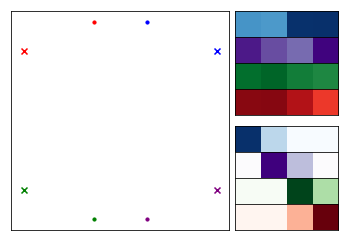

In [24]:
## plot method 2
plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)